# Янаков Дмитрий, 317

## **Название задания**: активации в CNN-1

## **Датасет**: SVHN

## **Цель задания**: выяснить, как зависит распределение активаций от следующих параметров - глубина, ширина, skip, BN, DO, init, оптимизатор

## 0. Подготовка

Для начала импортируем все необходимые библиотеки.

In [18]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import SVHN
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.utils import save_image
import torch.optim as optim
import math

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import dl_default
import dl_bn
import dl_depth
import dl_do
import dl_skip
import dl_weight
import dl_width
from training import train
from compare import get_comparison


%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

В качестве CNN была выбрана сеть **ResNet** с **18** слоями. \
На вход ей поступает изображение размером **224x224**. Поэтому, создавая даталоадеры, предварительно заресайзим картинки к этому размеру. Размер батча сделаем равным **64**.

In [ ]:
torch.manual_seed(43)
tranform_train = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
tranform_test = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_ds = SVHN(root='./data', split='train', download=True, transform=tranform_train)
val_size = 15000 
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size]) 
test_ds = SVHN(root='./data', split='test', download=True, transform=tranform_test)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

Примеры изображений из трейнового датасета приведены ниже (к ним уже применены все необходимые трансформации).

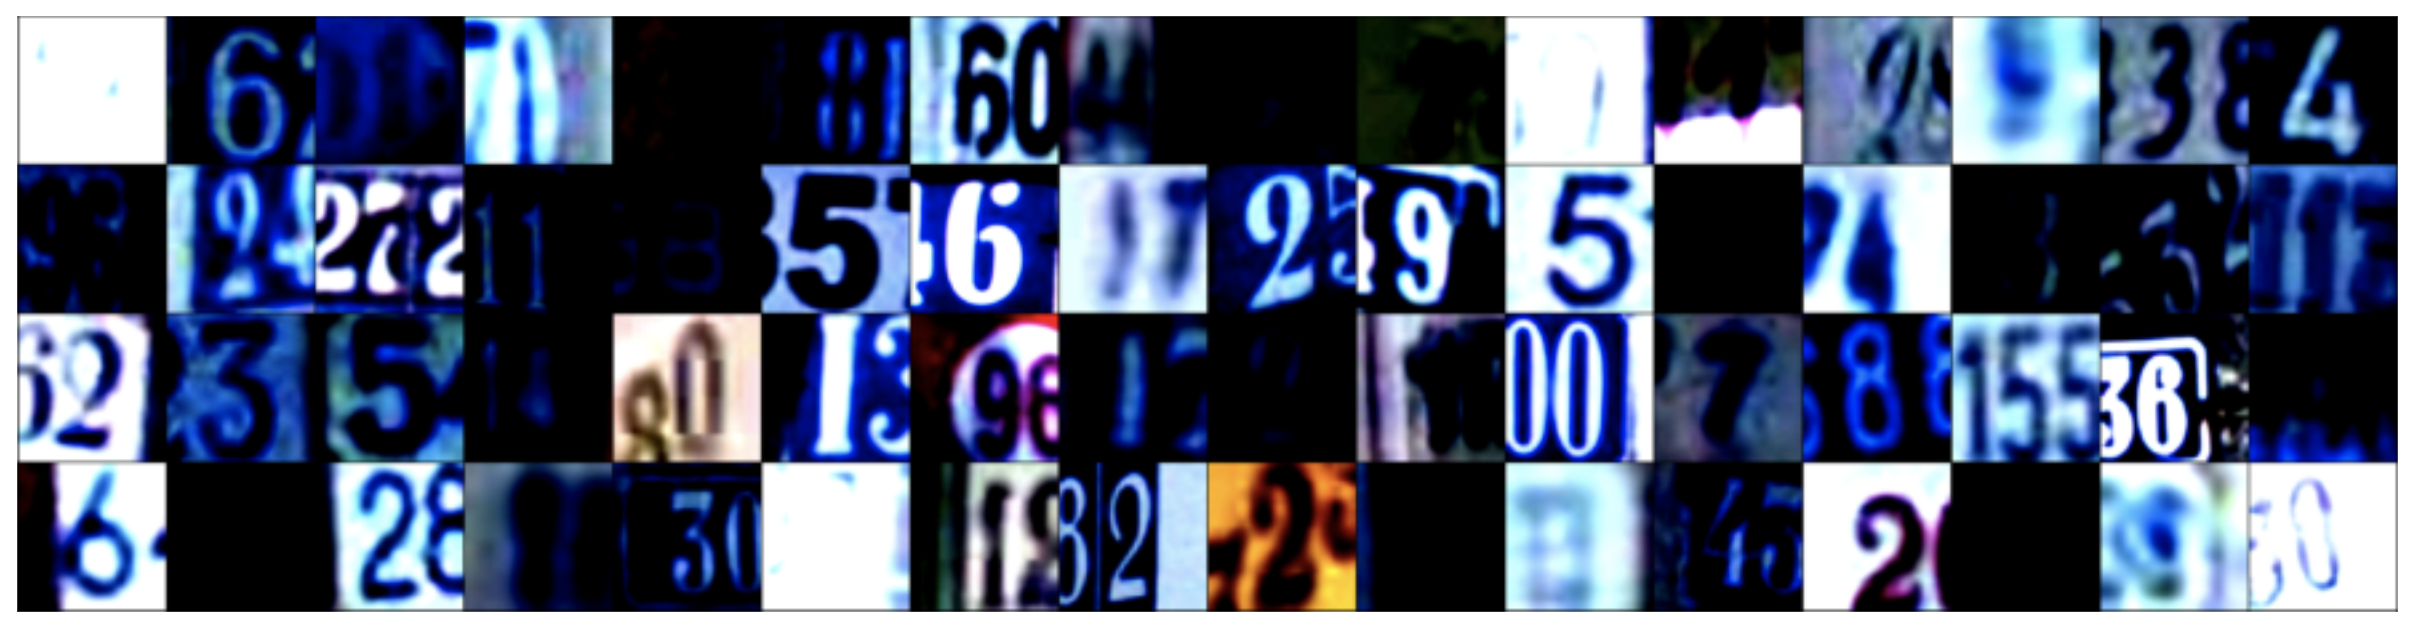

Реализация сети взята из библиботеки [**PyTorch**](https://chsasank.com/vision/_modules/torchvision/models/resnet.html#:~:text=def%20resnet18(pretrained%3DFalse%2C%20**kwargs)%3A). \
Определим параметры по умолчанию, которые в дальнейшем будем варьировать: \
* **глубина** - 18; \
* **ширина** - [64, 128, 256, 512] (по сути это out_channels в свёрточных слоях); \
* **skip** - используются; \
* **BN слои** - используются; \
* **DO слои** - не используются; \
* **инициализация весов** - из реализации (формулу см. ниже); \
* **optimizer** - SGD + Momentum (0.9).

Веса для свёрточных слоев генерируются из следующего распределения:

$$w \sim \mathcal{N} \left(0, \frac{2}{n}\right),$$ где $$n = kernel\_size[0] * kernel\_size[1] * out\_channels.$$

В качестве функции потерь выступает **кросс-энтропия**. Количество эпох для обучения - **15**.

In [15]:
criterion = nn.CrossEntropyLoss()
num_epochs = 15

Схема дальнейшего отчета такова:
1. обучение на параметрах по умолчанию;
2. варьирование (отдельно) каждого из параметров и соответствующее обучение;
3. анализ распределения активаций.

**P.S.:** для каждой новой обученной модели, будет оставлен вывод значений функции потерь и качества для каждой эпохи.

## 1. Обучение моделей

### 1.1 Для начала обучим сеть на параметрах **по умолчанию**.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = dl_default.resnet18() 
model = model.to(device=device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
train(device=device, model=model, num_epochs=num_epochs, optimizer=optimizer, criterion=criterion, train_dl=train_dl, val_dl=val_dl)

  0%|          | 0/15 [00:00<?, ?it/s]

Loss in epoch 0 :::: 1.008734648538146
Got 13436 / 15000 with accuracy 89.57
Loss in epoch 1 :::: 0.28545388980522246
Got 13745 / 15000 with accuracy 91.63
Loss in epoch 2 :::: 0.20945664932777538
Got 13912 / 15000 with accuracy 92.75
Loss in epoch 3 :::: 0.1632239504131508
Got 13949 / 15000 with accuracy 92.99
Loss in epoch 4 :::: 0.12363176279763653
Got 13946 / 15000 with accuracy 92.97
Loss in epoch 5 :::: 0.08912179394063881
Got 13946 / 15000 with accuracy 92.97
Loss in epoch 6 :::: 0.061491454629438114
Got 13934 / 15000 with accuracy 92.89
Loss in epoch 7 :::: 0.03744587388120154
Got 13914 / 15000 with accuracy 92.76
Loss in epoch 8 :::: 0.03308351082856635
Got 13924 / 15000 with accuracy 92.83
Loss in epoch 9 :::: 0.019822365343780284
Got 13987 / 15000 with accuracy 93.25
Loss in epoch 10 :::: 0.012714518216211383
Got 14015 / 15000 with accuracy 93.43
Loss in epoch 11 :::: 0.004158840895289608
Got 14088 / 15000 with accuracy 93.92
Loss in epoch 12 :::: 0.0026976341504601578
Got 1

In [ ]:
torch.save(model.state_dict(), "models/resnet_default.pth")

### 1.2 Поменяем **оптимизатор** на Adam.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = dl_default.resnet18() 
model = model.to(device=device)

optimizer = optim.Adam(model.parameters(), lr=1e-4 ) 

In [ ]:
train(device=device, model=model, num_epochs=num_epochs, optimizer=optimizer, criterion=criterion, train_dl=train_dl, val_dl=val_dl)

  0%|          | 0/15 [00:00<?, ?it/s]

Loss in epoch 0 :::: 0.9236344158093309
Got 13384 / 15000 with accuracy 89.23
Loss in epoch 1 :::: 0.2826893553873841
Got 13726 / 15000 with accuracy 91.51
Loss in epoch 2 :::: 0.21087673265981752
Got 13942 / 15000 with accuracy 92.95
Loss in epoch 3 :::: 0.1663675911471035
Got 13973 / 15000 with accuracy 93.15
Loss in epoch 4 :::: 0.12953972876987918
Got 13940 / 15000 with accuracy 92.93
Loss in epoch 5 :::: 0.09827259248051011
Got 13930 / 15000 with accuracy 92.87
Loss in epoch 6 :::: 0.06881377429820998
Got 13963 / 15000 with accuracy 93.09
Loss in epoch 7 :::: 0.05156152476413476
Got 13925 / 15000 with accuracy 92.83
Loss in epoch 8 :::: 0.03518058613270345
Got 13976 / 15000 with accuracy 93.17
Loss in epoch 9 :::: 0.03241659577043459
Got 13958 / 15000 with accuracy 93.05
Loss in epoch 10 :::: 0.025842986267052885
Got 13932 / 15000 with accuracy 92.88
Loss in epoch 11 :::: 0.030030014488562885
Got 13899 / 15000 with accuracy 92.66
Loss in epoch 12 :::: 0.02220869415832487
Got 13952

In [ ]:
torch.save(model.state_dict(), "models/resnet_optim.pth")

### 1.3 Уберём **skip connections**.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = dl_skip.resnet18_without_skip() 
model = model.to(device=device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
train(device=device, model=model, num_epochs=num_epochs, optimizer=optimizer, criterion=criterion, train_dl=train_dl, val_dl=val_dl)

  0%|          | 0/15 [00:00<?, ?it/s]

Loss in epoch 0 :::: 0.9637580638430383
Got 13513 / 15000 with accuracy 90.09
Loss in epoch 1 :::: 0.2655269111722348
Got 13877 / 15000 with accuracy 92.51
Loss in epoch 2 :::: 0.1973415162970448
Got 13947 / 15000 with accuracy 92.98
Loss in epoch 3 :::: 0.15663488098633865
Got 13995 / 15000 with accuracy 93.30
Loss in epoch 4 :::: 0.11984795951064672
Got 14029 / 15000 with accuracy 93.53
Loss in epoch 5 :::: 0.09198165656109346
Got 14008 / 15000 with accuracy 93.39
Loss in epoch 6 :::: 0.06542523016715596
Got 14005 / 15000 with accuracy 93.37
Loss in epoch 7 :::: 0.04419959642381012
Got 13966 / 15000 with accuracy 93.11
Loss in epoch 8 :::: 0.03164888560847593
Got 13952 / 15000 with accuracy 93.01
Loss in epoch 9 :::: 0.02720154828185463
Got 13993 / 15000 with accuracy 93.29
Loss in epoch 10 :::: 0.020380025042993303
Got 14033 / 15000 with accuracy 93.55
Loss in epoch 11 :::: 0.015110760621689966
Got 13975 / 15000 with accuracy 93.17
Loss in epoch 12 :::: 0.00978597992204097
Got 14046

In [ ]:
torch.save(model.state_dict(), "models/resnet_skip.pth")

### 1.4 Уберем слои **BatchNorm**.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = dl_bn.resnet18_without_BN() 
model = model.to(device=device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
train(device=device, model=model, num_epochs=num_epochs, optimizer=optimizer, criterion=criterion, train_dl=train_dl, val_dl=val_dl)

  0%|          | 0/15 [00:00<?, ?it/s]

Loss in epoch 0 :::: 2.2135904437231573
Got 2827 / 15000 with accuracy 18.85
Loss in epoch 1 :::: 1.2951283739505564
Got 12674 / 15000 with accuracy 84.49
Loss in epoch 2 :::: 0.40855375562030843
Got 13427 / 15000 with accuracy 89.51
Loss in epoch 3 :::: 0.29324528210184053
Got 13736 / 15000 with accuracy 91.57
Loss in epoch 4 :::: 0.2269431527430022
Got 13886 / 15000 with accuracy 92.57
Loss in epoch 5 :::: 0.18319508773463847
Got 13861 / 15000 with accuracy 92.41
Loss in epoch 6 :::: 0.14879694844736144
Got 13885 / 15000 with accuracy 92.57
Loss in epoch 7 :::: 0.11937744060478099
Got 13883 / 15000 with accuracy 92.55
Loss in epoch 8 :::: 0.09795759349031953
Got 13886 / 15000 with accuracy 92.57
Loss in epoch 9 :::: 0.08199381486473872
Got 13810 / 15000 with accuracy 92.07
Loss in epoch 10 :::: 0.0667630140650795
Got 13774 / 15000 with accuracy 91.83
Loss in epoch 11 :::: 0.0635501280493493
Got 13873 / 15000 with accuracy 92.49
Loss in epoch 12 :::: 0.0530698676862916
Got 13958 / 150

In [ ]:
torch.save(model.state_dict(), "models/resnet_bn.pth")

### 1.5 Добавим слои **DropOut**.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = dl_do.resnet18_with_DO() 
model = model.to(device=device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
train(device=device, model=model, num_epochs=num_epochs, optimizer=optimizer, criterion=criterion, train_dl=train_dl, val_dl=val_dl)

  0%|          | 0/15 [00:00<?, ?it/s]

Loss in epoch 0 :::: 1.4898310623956694
Got 12764 / 15000 with accuracy 85.09
Loss in epoch 1 :::: 0.3801928174106402
Got 13426 / 15000 with accuracy 89.51
Loss in epoch 2 :::: 0.2783872202513116
Got 13714 / 15000 with accuracy 91.43
Loss in epoch 3 :::: 0.22811178695390044
Got 13756 / 15000 with accuracy 91.71
Loss in epoch 4 :::: 0.1982182445092501
Got 13901 / 15000 with accuracy 92.67
Loss in epoch 5 :::: 0.17153991629296972
Got 13877 / 15000 with accuracy 92.51
Loss in epoch 6 :::: 0.15000531171539513
Got 13981 / 15000 with accuracy 93.21
Loss in epoch 7 :::: 0.12936263112913568
Got 13970 / 15000 with accuracy 93.13
Loss in epoch 8 :::: 0.10946439577493526
Got 13996 / 15000 with accuracy 93.31
Loss in epoch 9 :::: 0.09275645464065799
Got 14012 / 15000 with accuracy 93.41
Loss in epoch 10 :::: 0.07748453153049907
Got 14012 / 15000 with accuracy 93.41
Loss in epoch 11 :::: 0.06490049079601355
Got 13958 / 15000 with accuracy 93.05
Loss in epoch 12 :::: 0.05150545484378206
Got 13978 / 

In [ ]:
torch.save(model.state_dict(), "models/resnet_do.pth")

### 1.6 Изменим **веса** свёрточных слоев на инициализацию Kaiming.

Веса генерируются следующим образом:
$$w \sim \mathcal{N} \left(0, std^{2}\right),$$ где $$ std = \sqrt{2}* \sqrt{\frac{2}{fan\_in + fan\_out}}.$$

Вычисление fan_in и fan_out можно посмотреть в [документации](https://pytorch.org/docs/stable/_modules/torch/nn/init.html#:~:text=def%20_calculate_correct_fan(tensor%2C%20mode)%3A).

Была выбрана именно такая инициализация, так как она хорошо работает с функцией активации ReLU.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = dl_weight.resnet18_weight() 
model = model.to(device=device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
train(device=device, model=model, num_epochs=num_epochs, optimizer=optimizer, criterion=criterion, train_dl=train_dl, val_dl=val_dl)

  0%|          | 0/15 [00:00<?, ?it/s]

Loss in epoch 0 :::: 1.0191653462128896
Got 13437 / 15000 with accuracy 89.58
Loss in epoch 1 :::: 0.29330059876164544
Got 13648 / 15000 with accuracy 90.99
Loss in epoch 2 :::: 0.21189643069692815
Got 13845 / 15000 with accuracy 92.30
Loss in epoch 3 :::: 0.16063203221201308
Got 13931 / 15000 with accuracy 92.87
Loss in epoch 4 :::: 0.12004514984504354
Got 13931 / 15000 with accuracy 92.87
Loss in epoch 5 :::: 0.0812833099022843
Got 13862 / 15000 with accuracy 92.41
Loss in epoch 6 :::: 0.05779471121979908
Got 13852 / 15000 with accuracy 92.35
Loss in epoch 7 :::: 0.03807934781978097
Got 13962 / 15000 with accuracy 93.08
Loss in epoch 8 :::: 0.02537871097686315
Got 13899 / 15000 with accuracy 92.66
Loss in epoch 9 :::: 0.02117319887065156
Got 13885 / 15000 with accuracy 92.57
Loss in epoch 10 :::: 0.013178753517642229
Got 13976 / 15000 with accuracy 93.17
Loss in epoch 11 :::: 0.007728329615597946
Got 13947 / 15000 with accuracy 92.98
Loss in epoch 12 :::: 0.005456568896212041
Got 140

In [ ]:
torch.save(model.state_dict(), "models/resnet_weight.pth")

### 1.7 Уменьшим **ширину** сети.


Возьмём следующие out_channels: [32, 64, 128, 256] (то есть уменьшим каждое значение в два раза, по сравнению с дефолтным случаем).

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = dl_width.resnet18_less_width() 
model = model.to(device=device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, train_dl=train_dl, val_dl=val_dl)

In [25]:
train(device=device, model=model, num_epochs=num_epochs, optimizer=optimizer, criterion=criterion, train_dl=train_dl, val_dl=val_dl)

  0%|          | 0/15 [00:00<?, ?it/s]

Loss in epoch 0 :::: 1.1549650142143115
Got 13103 / 15000 with accuracy 87.35
Loss in epoch 1 :::: 0.3182019280836101
Got 13650 / 15000 with accuracy 91.00
Loss in epoch 2 :::: 0.23012911791286536
Got 13782 / 15000 with accuracy 91.88
Loss in epoch 3 :::: 0.1839630715385423
Got 13952 / 15000 with accuracy 93.01
Loss in epoch 4 :::: 0.1468211695527337
Got 13894 / 15000 with accuracy 92.63
Loss in epoch 5 :::: 0.11377950598773036
Got 13887 / 15000 with accuracy 92.58
Loss in epoch 6 :::: 0.09035374325701126
Got 13902 / 15000 with accuracy 92.68
Loss in epoch 7 :::: 0.06281676982211523
Got 13890 / 15000 with accuracy 92.60
Loss in epoch 8 :::: 0.05035930102165588
Got 13913 / 15000 with accuracy 92.75
Loss in epoch 9 :::: 0.030678691188999043
Got 13917 / 15000 with accuracy 92.78
Loss in epoch 10 :::: 0.019393457298953715
Got 13949 / 15000 with accuracy 92.99
Loss in epoch 11 :::: 0.018353611040317568
Got 13950 / 15000 with accuracy 93.00
Loss in epoch 12 :::: 0.012307620302540926
Got 1398

In [ ]:
torch.save(model.state_dict(), "models/resnet_narrow.pth")

### 1.8 Уменьшим **глубину** сети до 14 слоёв.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = dl_depth.resnet_less_depth() 
model = model.to(device=device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
train(device=device, model=model, num_epochs=num_epochs, optimizer=optimizer, criterion=criterion, train_dl=train_dl, val_dl=val_dl)

  0%|          | 0/15 [00:00<?, ?it/s]

Loss in epoch 0 :::: 1.5584301361006518
Got 11213 / 15000 with accuracy 74.75
Loss in epoch 1 :::: 0.523939460499619
Got 13261 / 15000 with accuracy 88.41
Loss in epoch 2 :::: 0.3372934533346498
Got 13529 / 15000 with accuracy 90.19
Loss in epoch 3 :::: 0.27018371818977704
Got 13584 / 15000 with accuracy 90.56
Loss in epoch 4 :::: 0.22799329177919125
Got 13774 / 15000 with accuracy 91.83
Loss in epoch 5 :::: 0.19257002418736072
Got 13811 / 15000 with accuracy 92.07
Loss in epoch 6 :::: 0.16546467828240274
Got 13753 / 15000 with accuracy 91.69
Loss in epoch 7 :::: 0.13734128747675178
Got 13741 / 15000 with accuracy 91.61
Loss in epoch 8 :::: 0.11278569449095054
Got 13851 / 15000 with accuracy 92.34
Loss in epoch 9 :::: 0.08929308592398068
Got 13755 / 15000 with accuracy 91.70
Loss in epoch 10 :::: 0.07143796517837764
Got 13739 / 15000 with accuracy 91.59
Loss in epoch 11 :::: 0.055025160403638
Got 13782 / 15000 with accuracy 91.88
Loss in epoch 12 :::: 0.040452977913328574
Got 13784 / 1

In [ ]:
torch.save(model.state_dict(), "models/resnet_less_depth.pth")

## 2. Анализ распределения активаций

Сгенерируем батч, на котором будем тестировать модели.

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for a, b in test_dl:
  data, target = a, b
  break

data = data.to(device=device)
target = target.to(device=device)

И пропустим его через дефолтную модель.

In [ ]:
model_1 = dl_default.resnet18_acc() 
model_1 = model_1.to(device=device)
model_1.load_state_dict(torch.load("models/resnet_default.pth")) 
model_1.eval()

Далее будут сравниваться распределения активаций на модели с дефолтными параметрами со всеми другими моделями.

### 2.1 Оптимизаторы

In [ ]:
model_2 = dl_default.resnet18_acc() 
model_2 = model_2.to(device=device)
model_2.load_state_dict(torch.load("models/resnet_optim.pth")) 
model_2.eval()

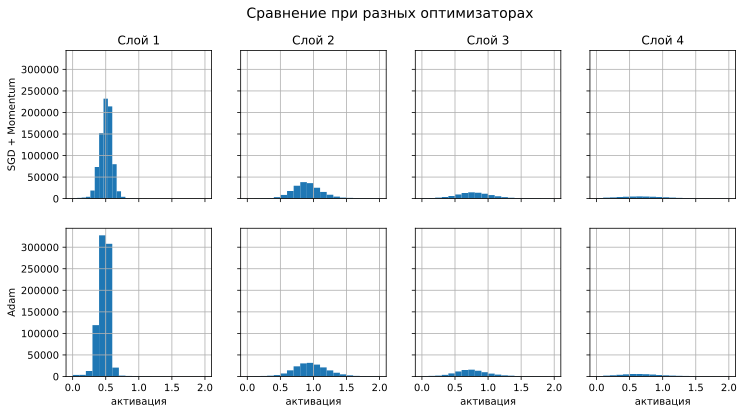

In [11]:
get_comparison(model_1, model_2, data, 'Сравнение при разных оптимизаторах', 'SGD + Momentum', 'Adam')

Здесь и далее, активации обрезаются до 2, так как активаций со значением > 2 очень мало.

Обозначения "Слой 1", "Слой 2" и т.д. условные, поскольку на самом деле активаций в сети применяется больше, поэтому были выбраны некоторые из них (но, разумеется, они идут по возрастанию от входа сети).

Можно заметить, что в начале, при использовании оптимизатора **Adam**, значений активаций около 0.5 больше, чем при использовании **SGD + Momentum**, однако на следующих слоях распределения очень похожи.

### 2.2 Skip

In [ ]:
model_2 = dl_skip.resnet18_without_skip_acc() 
model_2 = model_2.to(device=device)
model_2.load_state_dict(torch.load("models/resnet_skip.pth")) 
model_2.eval()

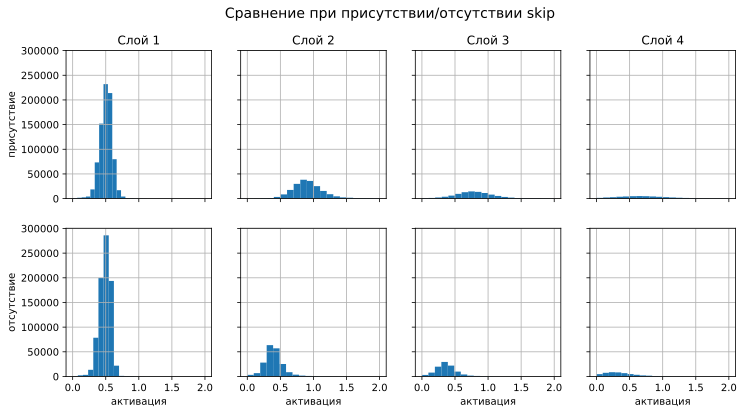

In [9]:
get_comparison(model_1, model_2, data, 'Сравнение при присутствии/отсутствии skip', 'присутствие', 'отсутствие')

Распределения активаций при отсутствии **skip connections** имеют меньшую дисперсию и более острые центры. К тому же, они быстрее смещаются к нулю.

### 2.3 Batch-Norm слои

In [ ]:
model_2 = dl_bn.resnet18_without_BN_acc() 
model_2 = model_2.to(device=device)
model_2.load_state_dict(torch.load("models/resnet_bn.pth")) 
model_2.eval()

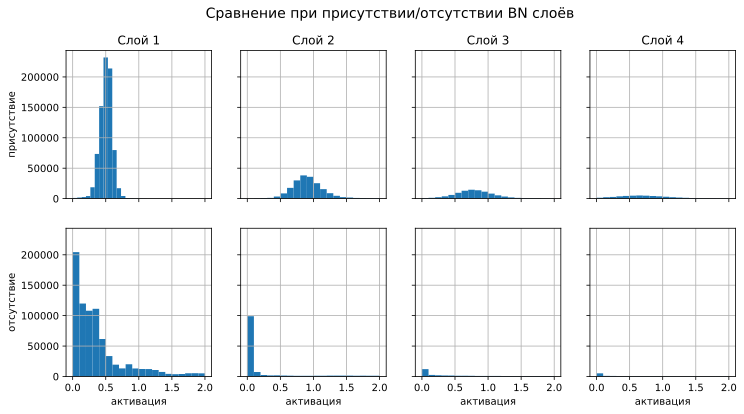

In [11]:
get_comparison(model_1, model_2, data, 'Сравнение при присутствии/отсутствии BN слоёв', 'присутствие', 'отсутствие')

При отсутствии **BatchNorm** слоев пик распределения смещается к нулю, затем, ближе к концу, выравнивается, что, конечно же, естественно, поскольку **BatchNorm** слои поддерживают средние значеня и дисперсии выходов.

### 2.4 DropOut слои

In [ ]:
model_2 = dl_do.resnet18_with_DO_acc() 
model_2 = model_2.to(device=device)
model_2.load_state_dict(torch.load("models/resnet_do.pth")) 
model_2.eval()

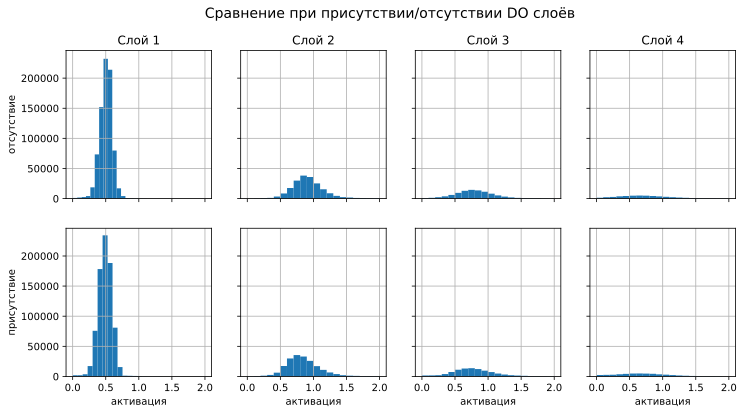

In [13]:
get_comparison(model_1, model_2, data, 'Сравнение при присутствии/отсутствии DO слоёв', 'отсутствие', 'присутствие')

Распределения активаций при добавлении **DropOut** слоев практически не изменились.

### 2.5 Инициализация весов

In [ ]:
model_2 = dl_weight.resnet18_weight_acc() 
model_2 = model_2.to(device=device)
model_2.load_state_dict(torch.load("models/resnet_weight.pth")) 
model_2.eval()

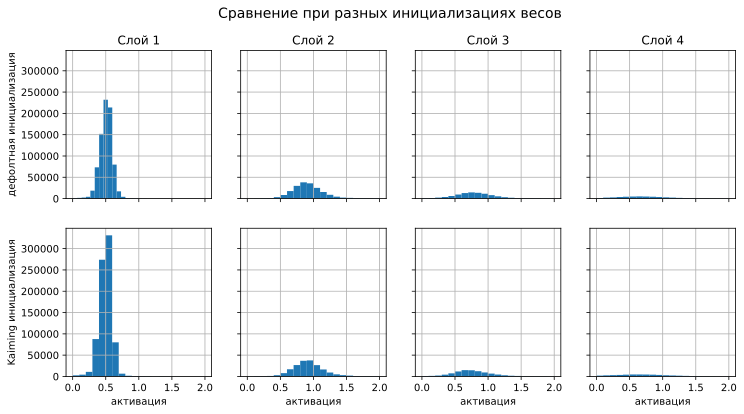

In [15]:
get_comparison(model_1, model_2, data, 'Сравнение при разных инициализациях весов', 'дефолтная инициализация', 'Kaiming инициализация')

Ситуация аналогична варьированию оптимизатора. При **Kaiming** инициализации вначале распределение имеет более острый пик, далее выравнивается схожим образом, как при дефолтной инициализации.

### 2.6 Ширина

In [ ]:
model_2 = dl_width.resnet18_less_width_acc() 
model_2 = model_2.to(device=device)
model_2.load_state_dict(torch.load("models/resnet_narrow.pth")) 
model_2.eval()

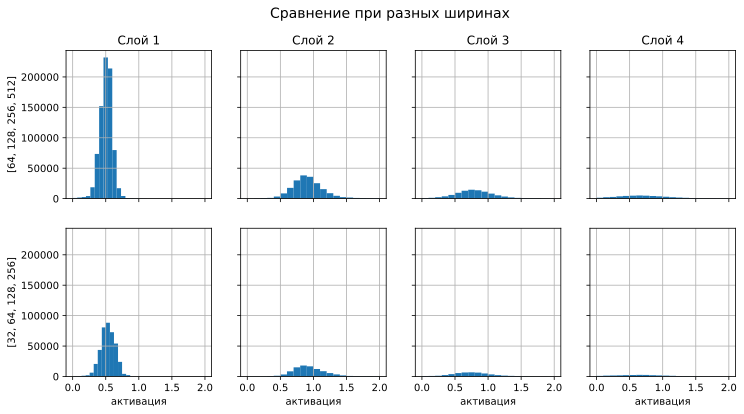

In [9]:
get_comparison(model_1, model_2, data, 'Сравнение при разных ширинах', '[64, 128, 256, 512]', '[32, 64, 128, 256]')

Видно, что пики распределений у узкой модели находятся примерно в два раза ниже, чем у широкой. Скорее всего, это связано с тем, что параметров в сети стало меньше => меньше активаций.

### 2.7 Глубина

In [ ]:
model_2 = dl_depth.resnet_less_depth_acc() 
model_2 = model_2.to(device=device)
model_2.load_state_dict(torch.load("models/resnet_less_depth.pth")) 
model_2.eval()

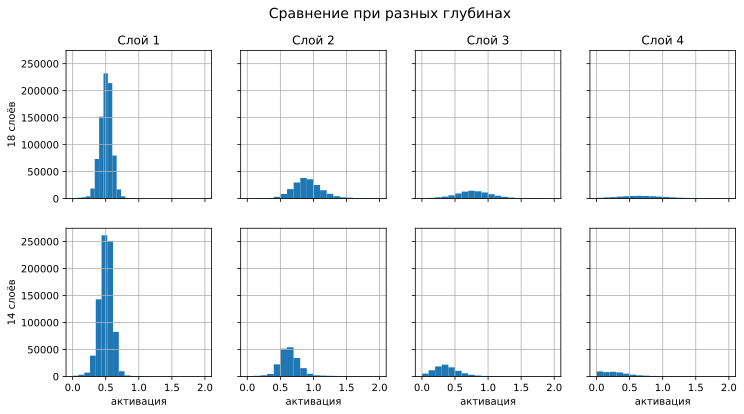

In [17]:
get_comparison(model_1, model_2, data, 'Сравнение при разных глубинах', '18 слоёв', '14 слоёв')

Сильной разницы в распределении между глубокой и неглубокой моделью не наблюдается. Единственное, что можно отметить, что пики распредедений у неглубокой модели чуть острее и само распределение быстрее движется к нулю (это отчетливо видно на последнем слое, где много значений сконцентрировалось в окрестности нуля).

## 3. Выводы

Исходя из экспериментов выше можно сделать несколько следующих выводов:
* распределение активаций мало зависит от **инициализации весов**, **оптимизаторов** и добавления слоёв **DropOut** (однако стоит отметить, что в данной архитектуре изначально использовались слои BatchNorm. Возможно, без них слои DropOut оказали бы более сильное воздействие);

* удаление **skip connections**, **BatchNorm** слоёв и использование **неглубокой архитектуры** приводит к более быстрому смещению (а вслучае удаления BatchNorm слоев к немедленному смещению) распределений к окрестности нуля;

* использование **менее широкой** сети приводит к уменьшению высоты колокола, образуемоего графиком распределения.

P.S.: некоторые функции были взяты [отсюда](https://github.com/Ti-Oluwanimi/Neural-Network-Classification-Algorithms/blob/main/VGG16.ipynb).